In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/Users/zhaluza/opt/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(
    root="../Data", train=True, download=True, transform=transform
)


Files already downloaded and verified


In [4]:
test_data = datasets.CIFAR10(
    root="../Data", train=False, download=True, transform=transform
)


Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
class_names = [
    "plane",
    "  car",
    " bird",
    "  cat",
    " deer",
    "  dog",
    " frog",
    "horse",
    " ship",
    "truck",
]


In [9]:
# View a batch of images
for images, labels in train_loader:
    break

In [10]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [3 2 0 4 9 5 1 2 4 8]
Class:   cat  bird plane  deer truck   dog   car  bird  deer  ship


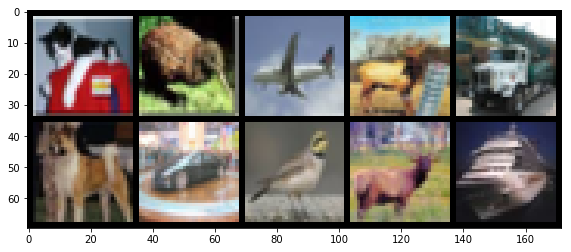

In [14]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


In [23]:
# Create our model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional_layer_1 = nn.Conv2d(3, 6, 5, 1)  # (1, 6, 5, 1)
        self.convolutional_layer_2 = nn.Conv2d(6, 16, 3, 1)
        self.fully_connected_1 = nn.Linear(6 * 6 * 16, 120)
        self.fully_connected_2 = nn.Linear(120, 84)
        self.fully_connected_3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.convolutional_layer_1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.convolutional_layer_2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6 * 6 * 16)
        X = F.relu(self.fully_connected_1(X))
        X = F.relu(self.fully_connected_2(X))
        X = self.fully_connected_3(X)
        return F.log_softmax(X, dim=1)


In [24]:
# Create our network
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (convolutional_layer_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (convolutional_layer_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fully_connected_1): Linear(in_features=576, out_features=120, bias=True)
  (fully_connected_2): Linear(in_features=120, out_features=84, bias=True)
  (fully_connected_3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
# check parameters
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [27]:
# Train the model
import time

start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b % 1000 == 0:
            print(
                f"epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%"
            )

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f"\nDuration: {time.time() - start_time:.0f} seconds")  # print the time elapsed


epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.62084031  accuracy:  26.890%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.33379769  accuracy:  32.540%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.90552926  accuracy:  35.897%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.65752959  accuracy:  38.260%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 2.29478955  accuracy:  40.054%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.24396014  accuracy:  49.220%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.63924122  accuracy:  49.805%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.81999958  accuracy:  50.033%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.97485352  accuracy:  50.620%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.83911669  accuracy:  51.112%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.93104619  accuracy:  55.130%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.35030675  accuracy:  55.200%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.28227592  accuracy:  55.430%
epoch:  2  b

In [28]:
# Save our model!
torch.save(model.state_dict(), 'myCIFARmodel.pt')

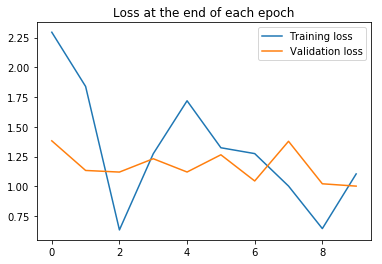

In [29]:
# Plot our model
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Loss at the end of each epoch")
plt.legend()


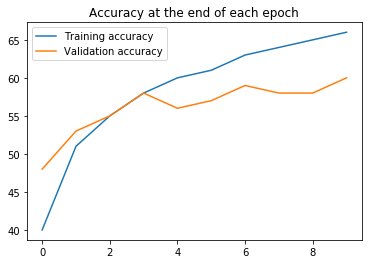

In [30]:
plt.plot([t / 500 for t in train_correct], label="Training accuracy")
plt.plot([t / 100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend();

In [32]:
total_correct = test_correct[-1].item()
print(f"Total of {total_correct * 100 / 10000}% correct")


Total of 60.87% correct


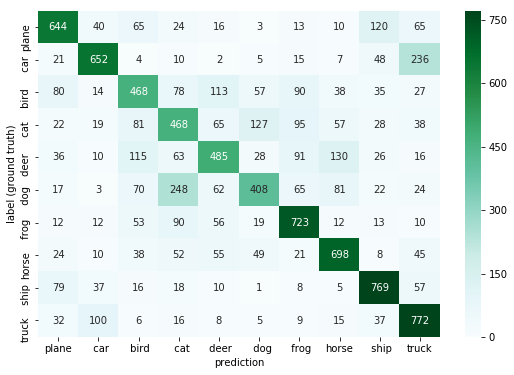

In [33]:
# Confusion matrix

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(9, 6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="BuGn")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()
